# Useful Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from EDMD import EDMD
from Observables import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A Linear Example


$$x(n+1) = Jx(n)$$

In [40]:
J = np.array([[0.9, -0.1],[0, 0.8]])

def linear_system(x):
    x_next = x@J.T
    return x_next

## Actual Eigenvalues


In [41]:
lambda_0, lambda_1 = scipy.linalg.eig(J)[0]
v_0 = scipy.linalg.eig(J)[1][:,0]
v_1 = scipy.linalg.eig(J)[1][:,1]
w_0 = scipy.linalg.eig(J, left=True)[1][:,0]
w_1 = scipy.linalg.eig(J, left=True)[1][:,1]
print(f"The matrix has eigenvalues {lambda_0} and {lambda_1}")
print(f"The matrix has eigenvectors {v_0} and {v_1}")
print(f"The matrix has left eigenvectors {w_0} and {w_1}")

The matrix has eigenvalues (0.9+0j) and (0.8+0j)
The matrix has eigenvectors [1. 0.] and [0.70710678 0.70710678]
The matrix has left eigenvectors [ 0.70710678 -0.70710678] and [0. 1.]


## Koopman Eigenfunction
This makes the Koopman eigenfunction as follows 
$$
\varphi_{n_{1}, n_{2}, \ldots, n_{N}}(\boldsymbol{x})=\prod_{i=1}^{N}\left(\boldsymbol{w}_{i}^{*} \boldsymbol{x}\right)^{n_{i}}
$$

and the cooresponding Koopman eigenvalues are 

$$
\prod_{i=1}^{N} \mu_{i}^{n_{i}}
$$
where $\boldsymbol{w}_{i}$ is the left eigenvector with cooresponding eigen values $\mu_i$


Hence for our linear case we get
$$
\varphi_{i,j} = (\frac{x}{\sqrt{2}}-\frac{y}{\sqrt{2}})^i(y)^j
$$
and
$$
\lambda_{i,j} = (0.9)^i(0.8)^j
$$

We will plot the results now

In [42]:
def linear_koopman_eigenfunction(X, Y, i,j):
    eigenfunc = (X/np.sqrt(2) - Y/np.sqrt(2))**i * (Y)**j
    eigenval = 0.9**i * 0.8**j
    return [eigenval, eigenfunc]

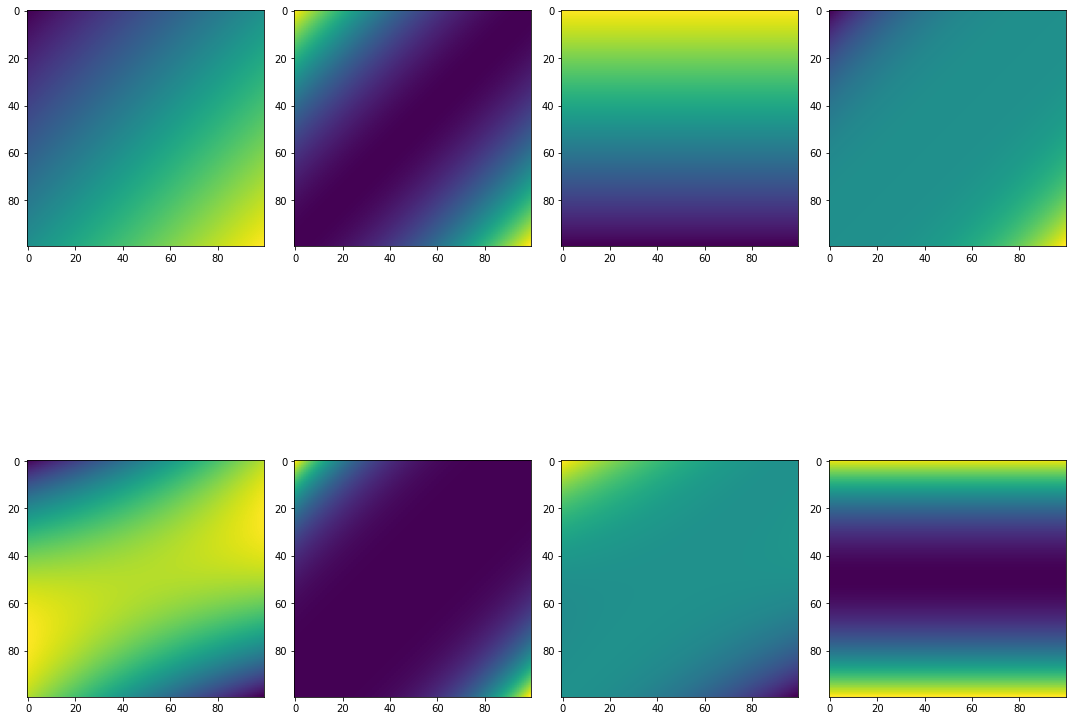

In [43]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X, Y = np.meshgrid(x,y)
# Flip array because we want numbering to start from bottom of array instead of the default top from numpy
X = np.flipud(X)
Y = np.flipud(Y)

ij_pair = [(1,0), (2,0), (0,1), (3,0), (1,1), (4,0), (2,1), (0,2)]
fig, axs = plt.subplots(2,4, figsize=(15,15))
axs = axs.flatten()
for index, ij in enumerate(ij_pair):
    i, j = ij
    s = axs[index].imshow(linear_koopman_eigenfunction(X, Y, i,j)[1])
    
plt.tight_layout()

## Generating Data

In [44]:
initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))).T.reshape(-1, 2)

In [45]:
x_linear = []
dt = 0.1
t_range = np.arange(0,5,dt)
x_sol = pd.DataFrame()
for i, ic in enumerate(initial_conditions):
    ic = ic.reshape(-1, ic.shape[0])
    x_linear = []
    y_linear = []
    x_linear.append(ic)
    for delta_t in t_range:
        x_linear.append(linear_system(x_linear[-1]))
        y_linear.append(x_linear[-1])
    y_linear.append(linear_system(x_linear[-1]))
    x_linear = np.array(x_linear).squeeze()
    y_linear = np.array(y_linear).squeeze()
    xy_linear = np.concatenate((x_linear, y_linear), axis=1)
    if x_sol is None:
        x_df = pd.DataFrame(xy_linear, columns=['x1', 'x2', 'y1', 'y2'])
        x_df.insert(0,'ID', i)
    else:
#         x_df = pd.DataFrame(x_linear, columns=['x1', 'x2'])
        x_df = pd.DataFrame(xy_linear, columns=['x1', 'x2', 'y1', 'y2'])
        x_df.insert(0,'ID', i)
        x_sol = pd.concat([x_sol, x_df], axis=0)


In [46]:
x_sol

,ID,x1,x2,y1,y2
0,0,-2.000000,-2.000000,-1.600000,-1.600000
1,0,-1.600000,-1.600000,-1.280000,-1.280000
2,0,-1.280000,-1.280000,-1.024000,-1.024000
3,0,-1.024000,-1.024000,-0.819200,-0.819200
4,0,-0.819200,-0.819200,-0.655360,-0.655360
...,...,...,...,...,...
46,63,0.000070,0.000070,0.000056,0.000056
47,63,0.000056,0.000056,0.000045,0.000045
48,63,0.000045,0.000045,0.000036,0.000036
49,63,0.000036,0.000036,0.000029,0.000029


Text(0.5, 1.0, 'Progress of the system from various initial conditions')

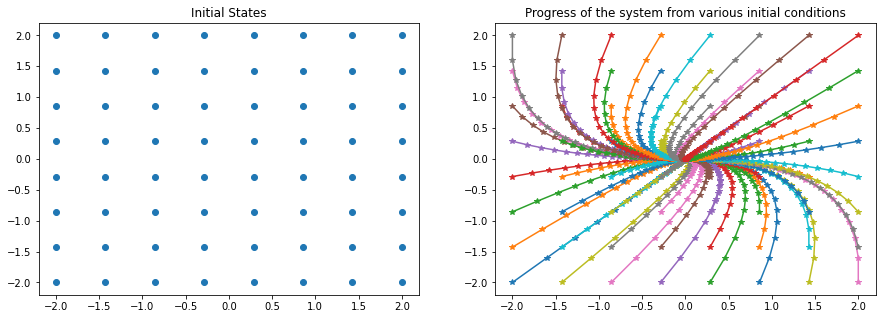

In [47]:
def plot_linear(data, ax):
    for id in data['ID'].unique():
        data_id = data[data['ID'] == id]
        plt.plot(data_id['x1'].to_numpy(), data_id['x2'].to_numpy(), marker='*')
    
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(initial_conditions[:,0], initial_conditions[:,1])
axs[0].set_title('Initial States')
plot_linear(x_sol, axs[1])
axs[1].set_title('Progress of the system from various initial conditions')


## Dictionary: Case - Hermite Polynomials

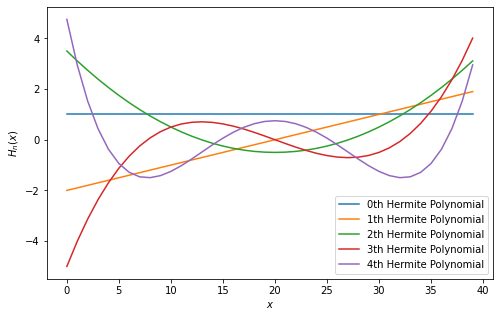

In [48]:
hermite_polys = []
a = np.arange(-2,2, 0.1)
hermite_polys.append(a)
fig, ax = plt.subplots(figsize=(8,5))
for i in range(5):
    hermite_poly = scipy.special.hermite(i, monic=True)
    hermite_polys.append(hermite_poly(a))
    ax.plot(hermite_polys[-1], label=f'{i}th Hermite Polynomial')
ax.set_xlabel('$x$')
ax.set_ylabel('$H_n(x)$')
plt.legend()

In [78]:
hermitian_observables = HermitePairs(5) # We will use the Hermite Pair dictionary as observables
hermitian_observables.fit(linear_edmd.x_data)

,ID,x1,x2,H0(x1)H0(x2),H0(x1)H1(x2),H0(x1)H2(x2),H0(x1)H3(x2),H0(x1)H4(x2),H1(x1)H0(x2),H1(x1)H1(x2),...,H3(x1)H0(x2),H3(x1)H1(x2),H3(x1)H2(x2),H3(x1)H3(x2),H3(x1)H4(x2),H4(x1)H0(x2),H4(x1)H1(x2),H4(x1)H2(x2),H4(x1)H3(x2),H4(x1)H4(x2)
0,0,-2.000000,-2.000000,1.0,-4.000000,14.000000,-40.000000,76.000000,-4.000000,1.600000e+01,...,-40.000000,1.600000e+02,-560.000000,1.600000e+03,-3040.000000,76.000000,-304.000000,1064.000000,-3040.000000,5776.000000
1,0,-1.600000,-1.600000,1.0,-3.200000,8.240000,-13.568000,-6.022400,-3.200000,1.024000e+01,...,-13.568000,4.341760e+01,-111.800320,1.840906e+02,81.711923,-6.022400,19.271680,-49.624576,81.711923,36.269302
2,0,-1.280000,-1.280000,1.0,-2.560000,4.553600,-1.417216,-23.693527,-2.560000,6.553600e+00,...,-1.417216,3.628073e+00,-6.453435,2.008501e+00,33.578846,-23.693527,60.655429,-107.890845,33.578846,561.383224
3,0,-1.024000,-1.024000,1.0,-2.048000,2.194304,3.698065,-20.739462,-2.048000,4.194304e+00,...,3.698065,-7.573638e+00,8.114680,1.367569e+01,-76.695887,-20.739462,42.474418,-45.508684,-76.695887,430.125282
4,0,-0.819200,-0.819200,1.0,-1.638400,0.684355,5.432353,-13.006495,-1.638400,2.684355e+00,...,5.432353,-8.900368e+00,3.717656,2.951046e+01,-70.655880,-13.006495,21.309842,-8.901054,-70.655880,169.168920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,63,0.000070,0.000070,1.0,0.000139,-2.000000,-0.000836,12.000000,0.000139,1.942669e-08,...,-0.000836,-1.165601e-07,0.001673,6.993608e-07,-0.010035,12.000000,0.001673,-23.999999,-0.010035,143.999994
47,63,0.000056,0.000056,1.0,0.000112,-2.000000,-0.000669,12.000000,0.000112,1.243308e-08,...,-0.000669,-7.459849e-08,0.001338,4.475909e-07,-0.008028,12.000000,0.001338,-24.000000,-0.008028,143.999996
48,63,0.000045,0.000045,1.0,0.000089,-2.000000,-0.000535,12.000000,0.000089,7.957172e-09,...,-0.000535,-4.774303e-08,0.001070,2.864582e-07,-0.006423,12.000000,0.001070,-24.000000,-0.006423,143.999998
49,63,0.000036,0.000036,1.0,0.000071,-2.000000,-0.000428,12.000000,0.000071,5.092590e-09,...,-0.000428,-3.055554e-08,0.000856,1.833332e-07,-0.005138,12.000000,0.000856,-24.000000,-0.005138,143.999999


# The EDMD Algorithm

In [75]:
linear_edmd = EDMD(x_sol, 2, hermitian_observables)
linear_edmd.fit()
linear_edmd.eigenvalues

array([1.        +0.j        , 0.9       +0.j        ,
       0.81      +0.j        , 0.8       +0.j        ,
       0.25679648+0.j        , 0.28354412+0.04217432j,
       0.28354412-0.04217432j, 0.72      +0.j        ,
       0.729     +0.j        , 0.6561    +0.j        ,
       0.64      +0.j        , 0.648     +0.j        ,
       0.37222724+0.02333948j, 0.37222724-0.02333948j,
       0.42926172+0.05659803j, 0.42926172-0.05659803j,
       0.4096    +0.j        , 0.42425367+0.j        ,
       0.5832    +0.j        , 0.576     +0.j        ,
       0.4608    +0.j        , 0.50349711+0.0220294j ,
       0.50349711-0.0220294j , 0.512     +0.j        ,
       0.5184    +0.j        ])

In [ ]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X, Y = np.meshgrid(x,y)

In [84]:
linear_edmd.eigenvectors_right[:,0]

array([ 1.00000000e+00+0.j, -4.87232610e-15+0.j,  2.77786085e-14+0.j,
        1.53580091e-16+0.j, -2.21437664e-15+0.j,  4.63293701e-15+0.j,
        7.01205417e-15+0.j, -7.44031077e-16+0.j,  7.82410505e-16+0.j,
        3.46377596e-17+0.j,  6.73382991e-15+0.j,  3.65979650e-16+0.j,
       -3.73361575e-15+0.j, -3.75893923e-17+0.j,  5.02649631e-16+0.j,
        2.15078808e-16+0.j, -4.94654616e-16+0.j,  1.60514948e-17+0.j,
       -1.57134359e-17+0.j,  8.05431161e-19+0.j,  1.80655271e-16+0.j,
       -4.74959650e-17+0.j,  8.30956079e-17+0.j,  8.02286109e-18+0.j,
       -4.52945941e-17+0.j])

In [85]:
hermitian_observables.fit(X)

TypeError: copy() got an unexpected keyword argument 'deep'

In [642]:
degree=3
x_data_obs = hermite_polynomials_dict(x_data, 5)
y_data_obs = hermite_polynomials_dict(y_data, 5)

In [643]:
y_data_obs

,ID,y1,y2,H0(x1)H0(x2),H0(x1)H1(x2),H0(x1)H2(x2),H0(x1)H3(x2),H0(x1)H4(x2),H1(x1)H0(x2),H1(x1)H1(x2),...,H3(x1)H0(x2),H3(x1)H1(x2),H3(x1)H2(x2),H3(x1)H3(x2),H3(x1)H4(x2),H4(x1)H0(x2),H4(x1)H1(x2),H4(x1)H2(x2),H4(x1)H3(x2),H4(x1)H4(x2)
0,0,-1.600000,-1.600000,1.0,-3.200000,8.240000,-13.568000,-6.022400,-3.200000,1.024000e+01,...,-13.568000,4.341760e+01,-111.800320,1.840906e+02,81.711923,-6.022400,19.271680,-49.624576,81.711923,36.269302
1,0,-1.280000,-1.280000,1.0,-2.560000,4.553600,-1.417216,-23.693527,-2.560000,6.553600e+00,...,-1.417216,3.628073e+00,-6.453435,2.008501e+00,33.578846,-23.693527,60.655429,-107.890845,33.578846,561.383224
2,0,-1.024000,-1.024000,1.0,-2.048000,2.194304,3.698065,-20.739462,-2.048000,4.194304e+00,...,3.698065,-7.573638e+00,8.114680,1.367569e+01,-76.695887,-20.739462,42.474418,-45.508684,-76.695887,430.125282
3,0,-0.819200,-0.819200,1.0,-1.638400,0.684355,5.432353,-13.006495,-1.638400,2.684355e+00,...,5.432353,-8.900368e+00,3.717656,2.951046e+01,-70.655880,-13.006495,21.309842,-8.901054,-70.655880,169.168920
4,0,-0.655360,-0.655360,1.0,-1.310720,-0.282013,5.612520,-5.664364,-1.310720,1.717987e+00,...,5.612520,-7.356442e+00,-1.582804,3.150038e+01,-31.791357,-5.664364,7.424395,1.597425,-31.791357,32.085019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,63,0.000056,0.000056,1.0,0.000112,-2.000000,-0.000669,12.000000,0.000112,1.243308e-08,...,-0.000669,-7.459849e-08,0.001338,4.475909e-07,-0.008028,12.000000,0.001338,-24.000000,-0.008028,143.999996
47,63,0.000045,0.000045,1.0,0.000089,-2.000000,-0.000535,12.000000,0.000089,7.957172e-09,...,-0.000535,-4.774303e-08,0.001070,2.864582e-07,-0.006423,12.000000,0.001070,-24.000000,-0.006423,143.999998
48,63,0.000036,0.000036,1.0,0.000071,-2.000000,-0.000428,12.000000,0.000071,5.092590e-09,...,-0.000428,-3.055554e-08,0.000856,1.833332e-07,-0.005138,12.000000,0.000856,-24.000000,-0.005138,143.999999
49,63,0.000029,0.000029,1.0,0.000057,-2.000000,-0.000343,12.000000,0.000057,3.259258e-09,...,-0.000343,-1.955555e-08,0.000685,1.173333e-07,-0.004110,12.000000,0.000685,-24.000000,-0.004110,143.999999


# Calculating G and A

$N_k = degree^2 = 9$

In [649]:
def construct_G(observables, Nk):
    G = np.zeros((Nk,Nk))
    for id in observables['ID'].unique():
        obs_m = observables[observables['ID'] == id].iloc[:,1:].to_numpy()
        G = G + obs_m.T @ obs_m
    M = observables['ID'].unique().max() + 1
    G = 1/M * G
    return G

def construct_A(observables_x, observables_y, Nk):
    A = np.zeros((Nk,Nk))
    for id in observables_x['ID'].unique():
        obs_m_x = observables_x[observables_x['ID'] == id].iloc[:,1:].to_numpy()
        obs_m_y = observables_y[observables_y['ID'] == id].iloc[:,1:].to_numpy()
        A = A + obs_m_x.T @ obs_m_y
    M = observables_x['ID'].unique().max() + 1
    A = 1/M * A
    return A

def get_observables(data, dim):
    observables = data.iloc[:,no_vars+1:]
    observables.insert(0, 'ID', x_sol_obs.iloc[:,0])
    return observables

no_vars = 2
# observables = x_sol_obs.iloc[:,no_vars+1:]
# observables.insert(0, 'ID', x_sol_obs.iloc[:,0])
x_obs = get_observables(x_data_obs, 5)
y_obs = get_observables(y_data_obs, 5)
x_obs

,ID,H0(x1)H0(x2),H0(x1)H1(x2),H0(x1)H2(x2),H0(x1)H3(x2),H0(x1)H4(x2),H1(x1)H0(x2),H1(x1)H1(x2),H1(x1)H2(x2),H1(x1)H3(x2),...,H3(x1)H0(x2),H3(x1)H1(x2),H3(x1)H2(x2),H3(x1)H3(x2),H3(x1)H4(x2),H4(x1)H0(x2),H4(x1)H1(x2),H4(x1)H2(x2),H4(x1)H3(x2),H4(x1)H4(x2)
0,0,1.0,-4.000000,14.000000,-40.000000,76.000000,-4.000000,1.600000e+01,-56.000000,1.600000e+02,...,-40.000000,1.600000e+02,-560.000000,1.600000e+03,-3040.000000,76.000000,-304.000000,1064.000000,-3040.000000,5776.000000
1,0,1.0,-3.200000,8.240000,-13.568000,-6.022400,-3.200000,1.024000e+01,-26.368000,4.341760e+01,...,-13.568000,4.341760e+01,-111.800320,1.840906e+02,81.711923,-6.022400,19.271680,-49.624576,81.711923,36.269302
2,0,1.0,-2.560000,4.553600,-1.417216,-23.693527,-2.560000,6.553600e+00,-11.657216,3.628073e+00,...,-1.417216,3.628073e+00,-6.453435,2.008501e+00,33.578846,-23.693527,60.655429,-107.890845,33.578846,561.383224
3,0,1.0,-2.048000,2.194304,3.698065,-20.739462,-2.048000,4.194304e+00,-4.493935,-7.573638e+00,...,3.698065,-7.573638e+00,8.114680,1.367569e+01,-76.695887,-20.739462,42.474418,-45.508684,-76.695887,430.125282
4,0,1.0,-1.638400,0.684355,5.432353,-13.006495,-1.638400,2.684355e+00,-1.121247,-8.900368e+00,...,5.432353,-8.900368e+00,3.717656,2.951046e+01,-70.655880,-13.006495,21.309842,-8.901054,-70.655880,169.168920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,63,1.0,0.000139,-2.000000,-0.000836,12.000000,0.000139,1.942669e-08,-0.000279,-1.165601e-07,...,-0.000836,-1.165601e-07,0.001673,6.993608e-07,-0.010035,12.000000,0.001673,-23.999999,-0.010035,143.999994
47,63,1.0,0.000112,-2.000000,-0.000669,12.000000,0.000112,1.243308e-08,-0.000223,-7.459849e-08,...,-0.000669,-7.459849e-08,0.001338,4.475909e-07,-0.008028,12.000000,0.001338,-24.000000,-0.008028,143.999996
48,63,1.0,0.000089,-2.000000,-0.000535,12.000000,0.000089,7.957172e-09,-0.000178,-4.774303e-08,...,-0.000535,-4.774303e-08,0.001070,2.864582e-07,-0.006423,12.000000,0.001070,-24.000000,-0.006423,143.999998
49,63,1.0,0.000071,-2.000000,-0.000428,12.000000,0.000071,5.092590e-09,-0.000143,-3.055554e-08,...,-0.000428,-3.055554e-08,0.000856,1.833332e-07,-0.005138,12.000000,0.000856,-24.000000,-0.005138,143.999999


In [651]:
G = construct_G(x_obs, 5**2)
A = construct_A(x_obs, y_obs, 5**2)
K = np.linalg.pinv(G) @ A

In [652]:
eigval, eigvec_l, eigvec_r = scipy.linalg.eig(K, left=True)

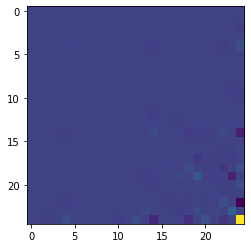

In [653]:
plt.imshow(A)

In [654]:
r = eigvec_r[:,0]
phi = y_obs.iloc[:,1:].to_numpy() @ r
# r

In [665]:
np.sort(eigval.real)


array([0.25679648, 0.28354412, 0.28354412, 0.37222724, 0.37222724,
       0.4096    , 0.42425367, 0.42926172, 0.42926172, 0.4608    ,
       0.50349711, 0.50349711, 0.512     , 0.5184    , 0.576     ,
       0.5832    , 0.64      , 0.648     , 0.6561    , 0.72      ,
       0.729     , 0.8       , 0.81      , 0.9       , 1.        ])

In [633]:
r.shape

(9,)

In [634]:
phi.shape

(3264,)

In [ ]:
hermitian_observables = HermitePairs()